In [7]:
# 載入套件
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud # pip install wordcloud
import matplotlib.pyplot as plt


In [18]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/wuanjie/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:

#下載POS tagger需要的資源
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /Users/wuanjie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/wuanjie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wuanjie/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [14]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']

In [15]:
book = open('raw_data/PRIDE & PREJUDICE.txt', mode='r', encoding="utf-8")
content = book.read()

In [16]:
content_dict = {'text': [content]}
content_df = pd.DataFrame(content_dict)
content_df

,text
0,﻿TPRIDE & PREJUDICE.\n\n\n\n\nCHAPTER I.\n\n\n...


### 3.2 斷句

In [21]:
content_df = content_df.assign(sentence = content_df['text'].apply(nltk.sent_tokenize)).explode('sentence').drop(['text'], axis=1)
content_df

,sentence
0,﻿TPRIDE & PREJUDICE.
0,CHAPTER I.
0,"It is a truth universally acknowledged, that a..."
0,However little known the feelings or views of ...
0,"""My dear Mr. Bennet,"" said his lady to him one..."
...,...
0,By Elizabeth's instructions she began to compr...
0,Lady Catherine was extremely indignant on the ...
0,"But at length, by Elizabeth's persuasion,\nhe ..."
0,"With the Gardiners, they were always on the mo..."


### 3.3 資料整理

使用re套件並用正規表達式比對出章節每個句子所屬的章節，並在DataFrame中新增一個章節(chapter)的欄位

In [22]:
def get_chapter_sentences(sentence): # 判斷句子中是否包含"CHAPTER"
    if re.search('CHAPTER', sentence) == None: 
        return 0
    else:
        return 1

content_df = content_df.assign(chapter = content_df['sentence'].apply(get_chapter_sentences).cumsum()) #cumsum: 累加函數
content_df

,sentence,chapter
0,﻿TPRIDE & PREJUDICE.,0
0,CHAPTER I.,1
0,"It is a truth universally acknowledged, that a...",1
0,However little known the feelings or views of ...,1
0,"""My dear Mr. Bennet,"" said his lady to him one...",1
...,...,...
0,By Elizabeth's instructions she began to compr...,61
0,Lady Catherine was extremely indignant on the ...,61
0,"But at length, by Elizabeth's persuasion,\nhe ...",61
0,"With the Gardiners, they were always on the mo...",61


### 3.4 移除無意義字、標點符號
清除CHAPTER的句子，並將長度小於1的句子刪除

清除文本中的標點符號、數字以及換行符號

In [23]:
# 刪除CHAPTER的列
content_df = content_df[~content_df["sentence"].str.contains("CHAPTER")]

# 刪除標點符號/數字/換行符號
content_df["sentence"] = content_df["sentence"].apply(lambda x: re.sub(r'[^\w\s]','', x))  #只留下英文字母和空格(包含換行符號)
content_df["sentence"] = content_df["sentence"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格
# content_df["sentence"] = content_df["sentence"].apply(lambda x: re.sub(r'\s+',' ', x)) 

# 刪除長度小於1的句子
content_df = content_df[~content_df["sentence"].str.len() < 1]

content_df

/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_15306/670373627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df["sentence"] = content_df["sentence"].apply(lambda x: re.sub(r'[^\w\s]','', x))  #只留下英文字母和空格(包含換行符號)
/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_15306/670373627.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df["sentence"] = content_df["sentence"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格


,sentence,chapter
0,TPRIDE PREJUDICE,0
0,It is a truth universally acknowledged that a ...,1
0,However little known the feelings or views of ...,1
0,My dear Mr Bennet said his lady to him one day...,1
0,Mr Bennet replied that he had not,1
...,...,...
0,By Elizabeths instructions she began to compre...,61
0,Lady Catherine was extremely indignant on the ...,61
0,But at length by Elizabeths persuasion he was ...,61
0,With the Gardiners they were always on the mos...,61


### 3.5 斷詞

使用NLTK的斷詞函式word_tokenize進行斷詞，將DataFrame處理成一個row一個斷詞的結果

In [24]:
token_df = content_df.assign(token = content_df['sentence'].apply(nltk.word_tokenize)).explode('token')
token_df

,sentence,chapter,token
0,TPRIDE PREJUDICE,0,TPRIDE
0,TPRIDE PREJUDICE,0,PREJUDICE
0,It is a truth universally acknowledged that a ...,1,It
0,It is a truth universally acknowledged that a ...,1,is
0,It is a truth universally acknowledged that a ...,1,a
...,...,...,...
0,Darcy as well as Elizabeth really loved them a...,61,the
0,Darcy as well as Elizabeth really loved them a...,61,means
0,Darcy as well as Elizabeth really loved them a...,61,of
0,Darcy as well as Elizabeth really loved them a...,61,uniting


### 3.6 字詞正規化

3.6.1 大小寫轉換

一種簡單的正規化方式為統一大小寫的字母，這樣在計算詞頻(或其他的匯總)時會將拼法一樣的字合併計算。

In [25]:
lowerWord_df = token_df.assign(word = token_df['token'].str.lower())
lowerWord_df

,sentence,chapter,token,word
0,TPRIDE PREJUDICE,0,TPRIDE,tpride
0,TPRIDE PREJUDICE,0,PREJUDICE,prejudice
0,It is a truth universally acknowledged that a ...,1,It,it
0,It is a truth universally acknowledged that a ...,1,is,is
0,It is a truth universally acknowledged that a ...,1,a,a
...,...,...,...,...
0,Darcy as well as Elizabeth really loved them a...,61,the,the
0,Darcy as well as Elizabeth really loved them a...,61,means,means
0,Darcy as well as Elizabeth really loved them a...,61,of,of
0,Darcy as well as Elizabeth really loved them a...,61,uniting,uniting


3.6.2 Stemming

Stemming是將資料使用字根的方式表達，也就是說會將後面的多餘的字尾去除掉，像是"ing"、複數型態等等的。這裡使用NLTK套件中的PorterStemmer來示範

In [26]:
# 初始化一個PorterStemmer的物件，並存在porter變數中
porter = PorterStemmer()
type(porter)

nltk.stem.porter.PorterStemmer

用簡單的句子先示範還原字根後的結果

In [27]:
text = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."
tokens = nltk.word_tokenize(text)
print("原句的斷詞結果：\n", tokens)
print("還原後：\n", [porter.stem(x) for x in tokens])

原句的斷詞結果：
 ['He', 'was', 'running', 'and', 'eating', 'at', 'same', 'time', '.', 'He', 'has', 'bad', 'habit', 'of', 'swimming', 'after', 'playing', 'long', 'hours', 'in', 'the', 'Sun', '.']
還原後：
 ['he', 'wa', 'run', 'and', 'eat', 'at', 'same', 'time', '.', 'he', 'ha', 'bad', 'habit', 'of', 'swim', 'after', 'play', 'long', 'hour', 'in', 'the', 'sun', '.']


In [28]:
# 小提醒：nltk許多function變數規定為字串，因此可以先將word轉為字串格式，以確保後續不會有錯誤
lowerWord_df['word'] = lowerWord_df['word'].astype(str)
stem_df = lowerWord_df.assign(stem_token = lowerWord_df['word'].apply(porter.stem)).reset_index(drop=True)

stem_df


,sentence,chapter,token,word,stem_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic
2,It is a truth universally acknowledged that a ...,1,It,it,it
3,It is a truth universally acknowledged that a ...,1,is,is,is
4,It is a truth universally acknowledged that a ...,1,a,a,a
...,...,...,...,...,...
121615,Darcy as well as Elizabeth really loved them a...,61,the,the,the
121616,Darcy as well as Elizabeth really loved them a...,61,means,means,mean
121617,Darcy as well as Elizabeth really loved them a...,61,of,of,of
121618,Darcy as well as Elizabeth really loved them a...,61,uniting,uniting,unit


### 3.7 移除停用字

停用字(Stopwords)是指那些對於分析沒有用的字詞，通常在進行文字分析時我們會將其去除，以避免一些雜訊的產生。這裡我們使用了NLTK套件中所提供的英文停用字資料來進行移除停用字的依據。初次使用的時候可以用以下的程式來下載預設停用字、或者是可以加入一些自訂的停用字詞。

In [29]:
# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')

# 使用nltk的stop_words
stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wuanjie/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
noStop_df = stem_df[~stem_df['word'].isin(stops)]
noStop_df

,sentence,chapter,token,word,stem_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic
5,It is a truth universally acknowledged that a ...,1,truth,truth,truth
6,It is a truth universally acknowledged that a ...,1,universally,universally,univers
7,It is a truth universally acknowledged that a ...,1,acknowledged,acknowledged,acknowledg
...,...,...,...,...,...
121606,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person
121609,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bring
121612,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshir
121616,Darcy as well as Elizabeth really loved them a...,61,means,means,mean


可以注意到資料筆數的變化，移除停用字之後大幅減少

### 3.8 計算字頻

用 lemma 過後的字來計算詞頻，以確保不會有同一個字單複數(work、works)、動詞與分詞(bring、bringing)被當作不一樣的詞。
並建立一個詞頻表的DataFrame

In [31]:
freq_df = pd.DataFrame(noStop_df['stem_token'].value_counts()).reset_index()
freq_df.columns = ['word', 'freq']
freq_df.head(15)

,word,freq
0,mr,1114
1,elizabeth,618
2,could,521
3,would,467
4,darci,410
5,said,398
6,bennet,331
7,much,327
8,must,308
9,bingley,307


### 3.9 視覺化結果

使用視覺化的圖表可以更加清楚的呈現分析結果

#### 長條圖
利用長條圖將詞頻表以視覺化的方式呈現，並且字頻為由大到小排序

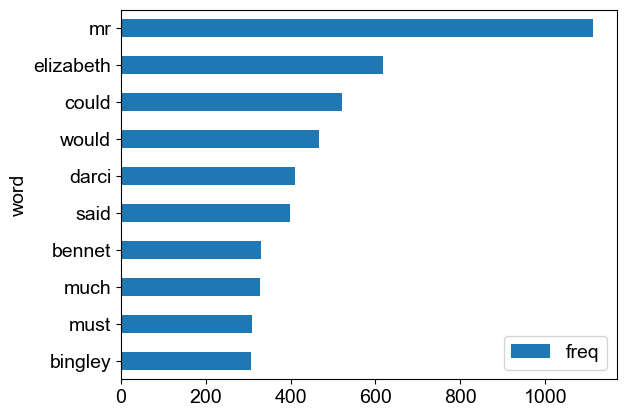

In [32]:
freq_df.iloc[:10].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

#### 折線圖
依照各章節句數、與字數來計算

In [33]:
chapter_count = pd.DataFrame({
    'chapter': content_df.groupby('chapter').size().index,
    'sentences': content_df.groupby('chapter').size().values,
    'word': token_df.groupby('chapter').size().values,
})
chapter_count[:10]

,chapter,sentences,word
0,0,1,2
1,1,61,855
2,2,53,802
3,3,86,1706
4,4,53,1060
5,5,48,929
6,6,106,2334
7,7,97,1984
8,8,111,1937
9,9,106,1732


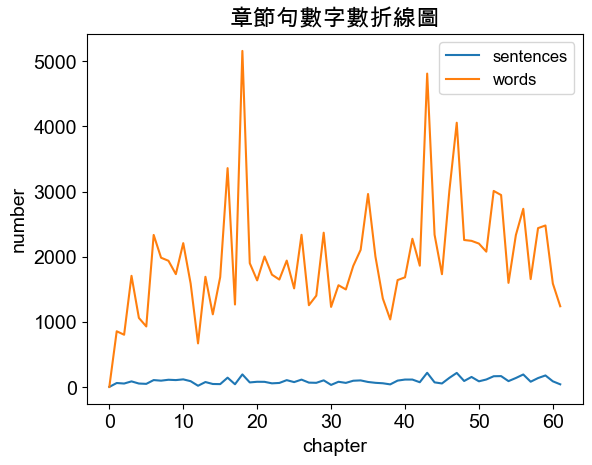

In [34]:
plt.plot(chapter_count['chapter'].values, chapter_count['sentences'].values ,label = 'sentences')
plt.plot(chapter_count['chapter'].values, chapter_count['word'].values, label = 'words')

plt.title('章節句數字數折線圖') # 標題
plt.xlabel('chapter') # x軸標題
plt.ylabel('number') # y軸標題
plt.legend(fontsize=12) # 顯示label
plt.show()

#### 文字雲
利用詞頻製作文字雲，並顯示出詞頻最高的單字

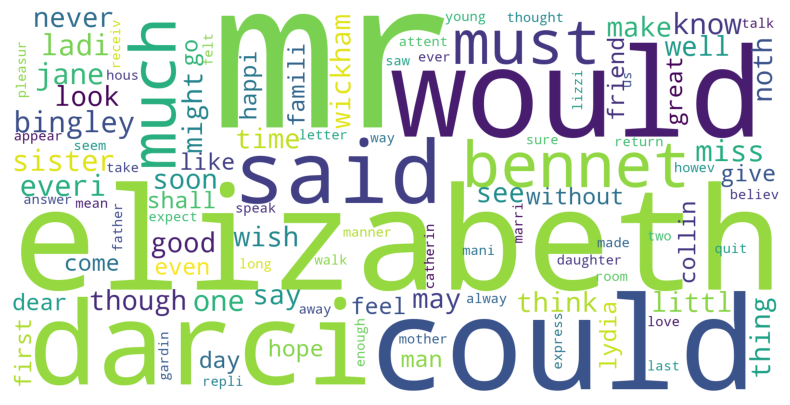

In [35]:
text = freq_df.set_index('word').to_dict()
wordcloud = WordCloud(scale = 4, background_color = 'white', max_words=100).generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 3.10 更新停用字字典
手動將停用字加入NLTK的停用字字典中

透過以上的字頻表與文字雲，我們可以發現could、would、much、must這些詞出現很多次，但這些字對於文本分析並不那麼重要，因次我們將這些字加入停用字字典中將他們清除

In [36]:
# 手動加入停用字
newStops = ['could', 'would', 'much', 'must']
stops.extend(newStops)

重新篩選出不是停用字的字

In [37]:
noStop_df = noStop_df[~noStop_df['word'].isin(stops)]
noStop_df

,sentence,chapter,token,word,stem_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic
5,It is a truth universally acknowledged that a ...,1,truth,truth,truth
6,It is a truth universally acknowledged that a ...,1,universally,universally,univers
7,It is a truth universally acknowledged that a ...,1,acknowledged,acknowledged,acknowledg
...,...,...,...,...,...
121606,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person
121609,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bring
121612,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshir
121616,Darcy as well as Elizabeth really loved them a...,61,means,means,mean


重新計算詞頻

In [38]:
freq_df2 = pd.DataFrame(noStop_df['stem_token'].value_counts())
freq_df2 = freq_df2.reset_index()
freq_df2.columns = ['word', 'freq']
freq_df2.head(15)

,word,freq
0,mr,1114
1,elizabeth,618
2,darci,410
3,said,398
4,bennet,331
5,bingley,307
6,one,298
7,sister,288
8,jane,286
9,miss,285


重新繪製詞頻表

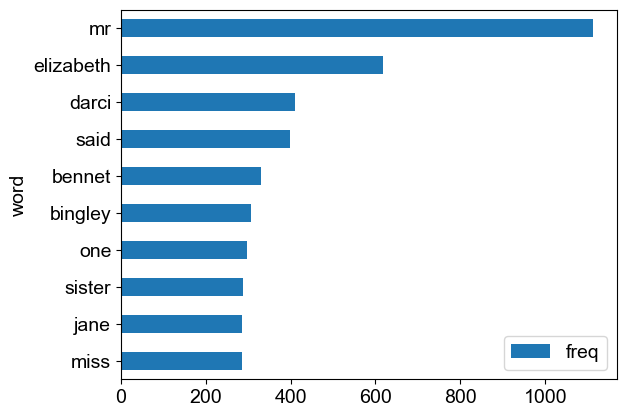

In [39]:
freq_df2.iloc[:10].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

### 3.11 斷詞字典

英文的文集段詞方式會以空白來斷詞，但有許多專有名詞、地名、人名、名詞片語等(ex.Natural Language Processing、United States、Lydia Bennet)屬於多個字組合才是完整的字詞，這類的字不應該在斷詞時被斷開，因此通常會使用底線來將這些應該合併的字連在一起，使這些字在做斷詞時不會被斷開。

在以上的詞頻表中，可以發現前10多的字有許多人名如Elizabeth、Bennet、BingLey、Jane，而Bennet所指的有可能是Mr. Bennet或是Mrs. Bennet，但在斷詞時會將兩個字分開來，因此我們可以透過將原文中的Mr Bennet和Mrs Bennet用Mr_Bennet和Mrs_Bennet取代

In [40]:
content_df["sentence"] = content_df["sentence"].replace({'Mr ': 'Mr_', 'Mrs ': 'Mrs_'}, regex=True)
content_df

,sentence,chapter
0,TPRIDE PREJUDICE,0
0,It is a truth universally acknowledged that a ...,1
0,However little known the feelings or views of ...,1
0,My dear Mr_Bennet said his lady to him one day...,1
0,Mr_Bennet replied that he had not,1
...,...,...
0,By Elizabeths instructions she began to compre...,61
0,Lady Catherine was extremely indignant on the ...,61
0,But at length by Elizabeths persuasion he was ...,61
0,With the Gardiners they were always on the mos...,61


取代完後需要重新進行斷詞、stemming

In [41]:
# 斷詞
new_df = content_df.assign(token = content_df['sentence'].apply(nltk.word_tokenize)).explode('token')

# 換小寫
new_df = new_df.assign(word = new_df['token'].str.lower())
new_df['word'] = new_df['word'].astype(str)

# 生成stem_token欄位
new_stem_df = new_df.assign(stem_token = new_df['word'].apply(porter.stem)).reset_index(drop=True)

# 移除停用字
new_noStop_df = new_stem_df[~new_stem_df['word'].isin(stops)]

new_noStop_df

,sentence,chapter,token,word,stem_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudic
5,It is a truth universally acknowledged that a ...,1,truth,truth,truth
6,It is a truth universally acknowledged that a ...,1,universally,universally,univers
7,It is a truth universally acknowledged that a ...,1,acknowledged,acknowledged,acknowledg
...,...,...,...,...,...
120526,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person
120529,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bring
120532,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshir
120536,Darcy as well as Elizabeth really loved them a...,61,means,means,mean


重新計算詞頻

In [42]:
new_freq_df = pd.DataFrame(new_noStop_df['stem_token'].value_counts())
new_freq_df = new_freq_df.reset_index()
new_freq_df.columns = ['word', 'freq']
new_freq_df.head(15)

,word,freq
0,elizabeth,618
1,said,398
2,one,298
3,sister,288
4,jane,286
5,miss,285
6,everi,282
7,know,271
8,ladi,261
9,mr_darci,248


重新畫出文字雲，可以看到文字雲中出現mrs_bennet，並沒有mr_bennet，代表在文本中Mrs. bennet的出現次數比Mr. bennet多

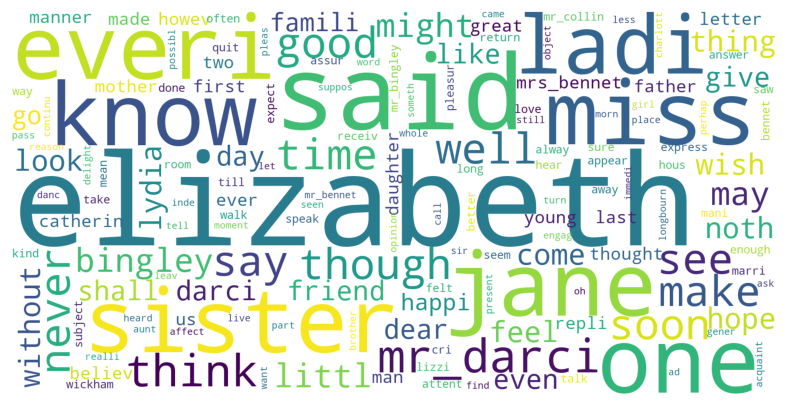

In [43]:
text2 = new_freq_df.set_index('word').to_dict()
wordcloud_2 = WordCloud(scale = 4, background_color = 'white').generate_from_frequencies(text2['freq'])
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(wordcloud_2)